# Import

In [1]:
from time import time
from datetime import datetime
import os

import geopandas as gpd
from shapely.geometry import Point
from geopandas.plotting import plot_polygon_collection, plot_dataframe
import pandas as pd
import seaborn as sns

import matplotlib as mp
from matplotlib import pyplot as plt
from matplotlib.collections import LineCollection

import numpy as np
import pysal as ps
import random as rdm
from pysal.contrib.viz import mapping as maps

/home/sbuss/envs/sb827/local/lib/python2.7/site-packages/pysal/contrib/viz/mapping.py:33: UserWarning: Bokeh not installed. Functionality related to it will not work
  warn('Bokeh not installed. Functionality ' \


## Useful links

* http://geopandas.org/mapping.html
* http://darribas.org/gds15/content/labs/lab_03.html
* http://jose-coto.com/plotting-geopandas
* http://nbviewer.jupyter.org/github/pysal/pysal/blob/master/pysal/contrib/viz/taz_example.ipynb?create=1
* http://nbviewer.jupyter.org/gist/perrygeo/c426355e40037c452434


# Data Loading

## data sources
* https://data.cityofberkeley.info/City-Government/Zoning-Districts/2dtu-vge3
* https://data.cityofberkeley.info/City-Government/Parcels/bhxd-e6up
* https://data.cityofberkeley.info/Transportation/Streets-Network/hqnk-qfhq
* http://www.acgov.org/MS/prop/useCodeList.aspx
* http://www.codepublishing.com/CA/Berkeley/html/pdfs/Berkeley23E.pdf
* http://www.codepublishing.com/CA/Berkeley/?Berkeley23A/Berkeley23A16/Berkeley23A16020.html&?f

In [45]:
all_parcels = gpd.read_file("gis/berkeley/Parcels.geojson").to_crs({'init': u'epsg:2227'})
# Exclude the Marina because it's huge and irrelevant
all_parcels = all_parcels[all_parcels['parcelid'] != '060 254500100']

In [39]:
zoning = gpd.read_file("gis/berkeley/Zoning Districts.geojson").to_crs({'init': u'epsg:2227'})

In [46]:
all_parcels_with_zoning = gpd.sjoin(all_parcels, zoning)
del all_parcels_with_zoning['index_right']

In [41]:
streets = gpd.read_file(os.path.realpath("gis/berkeley/Streets Network.geojson")).to_crs({'init': u'epsg:2227'})
wide_street_names = set([
    'UNIVERSITY',
    'SAN PABLO',
    'STANFORD',
    'M L KING JR',
    'SHATTUCK',
    'ADELINE',
])

def is_wide_street(ds):
    return ds['street_nam'] in wide_street_names

wide_streets = streets[streets.apply(is_wide_street, axis=1)]
narrow_streets = streets.loc[streets.index.difference(wide_streets.index)]

In [47]:

residential_zones = [
 u'C-1',
 u'C-N',
 u'C-N(H)',
 u'C-E',
 u'C-NS',
 u'C-NS(H)',
 u'C-SA',
 u'C-T',
 u'C-SO',
 u'C-W',
 u'C-DMU Buffer',
 u'C-DMU Core',
 u'C-DMU Corridor',
 u'C-DMU Outer Core',
 u'MUR',
 u'R-1',
 u'R-1A',
 u'R-1H',
 u'R-2',
 u'R-2A',
 u'R-2AH',
 u'R-2H',
 u'R-3',
 u'R-3H',
 u'R-4',
 u'R-4H',
 u'R-5',
 u'R-5H',
 u'R-S',
 u'R-SH',
 u'R-SMU',
]
residential_parcels = all_parcels_with_zoning[all_parcels_with_zoning.zoning.isin(residential_zones)]
residential_parcels['use_code'] = residential_parcels['use_code'].astype('int')

# Find high-quality bus stops

SB 827 defines a "high quality bus stop" as

> (d) “High-quality transit corridor” means a corridor with fixed route bus service that has service intervals of no more than 15 minutes during peak commute hours.

"Peak commute hours" aren't defined, but transitrichhousing.org uses 6:30am-8:30am and 4:30pm-6:30pm, so I'm going to use that too, until a definition is added to the law.

In [55]:
cal_attrs = pd.read_csv('gis/berkeley/GTFSTransitData_AC/calendar_attributes.txt')
weekdays = cal_attrs[cal_attrs.service_description.str.startswith('Weekday')]

In [62]:
all_trips = pd.read_csv('gis/berkeley/GTFSTransitData_AC/trips.txt')
weekday_trips = all_trips[all_trips.service_id.isin(weekdays.service_id)]

In [377]:
###
# This computes approximate stop frequencies based on AC Transit's incomplete raw data
###

# stop_times = pd.read_csv('gis/berkeley/GTFSTransitData_AC/stop_times.txt', delimiter=',')
# weekday_stop_times = stop_times[stop_times.trip_id.isin(weekday_trips.trip_id)]
# # Ignore the post-midnight buses
# weekday_stop_times = weekday_stop_times[~weekday_stop_times.arrival_time.str.split(':').str.get(0).isin([str(x) for x in range(24, 32)])]

# # There's an issue with stop_times: many rows have no arrival_time or departure_time
# # but they lie on a route that has gaps in those times, eg:
# #
# #     trip_id,arrival_time,departure_time,stop_id,stop_sequence,stop_headsign,pickup_type,drop_off_type,shape_dist_traveled,timepoint
# #     "5872012","6:00:00","6:00:00","51110","1",,"0","0",,1
# #     "5872012",,,59444,2,,"0","0",,0
# #     "5872012",,,54777,3,,"0","0",,0
# #     "5872012",,,51536,4,,"0","0",,0
# #     "5872012",,,59999,5,,"0","0",,0
# #     "5872012",,,50541,6,,"0","0",,0
# #     "5872012","6:11:00","6:11:00","50545","7",,"0","0",,1
# #
# # The simplest fix is to approximate the stop times on the route as an equal interval.

# fixed_stops = weekday_stop_times.copy(deep=True)
# # Find all rows with a non-null arrival time
# non_null = fixed_stops.dropna(subset=['arrival_time'])
# # Weekday stop times can be assumed to be valid for any Monday,
# # so for time parsing convenience, choose Monday April 2, 2018
# non_null.loc[:, 'arrival_time'] = "2018-04-02 " + non_null['arrival_time']
# non_null.loc[:, 'arrival_time'] = pd.to_datetime(non_null['arrival_time'])
# non_null.loc[:, 'departure_time'] = "2018-04-02 " + non_null['departure_time']
# non_null.loc[:, 'departure_time'] = pd.to_datetime(non_null['departure_time'])
# trips = non_null.groupby('trip_id')
# prev = None
# print("Num groups: %s" % len(trips.groups))
# c = 0
# for trip_id, idx in trips.groups.iteritems():
#     dts = [[],[]]
#     c += 1
#     if c % 250 == 0:
#         print(c)
#     for tidx, trip in non_null.loc[idx].sort_values('stop_sequence').iterrows():
#         dts[0].append(tidx)
#         dts[1].append((trip['arrival_time'], trip['departure_time']))
#         if prev is None:
#             prev = trip
#             continue
#         stop_seq_delta = trip['stop_sequence'] - prev['stop_sequence']
#         if stop_seq_delta > 1:
#             delta = (trip['departure_time'] - prev['arrival_time']) / stop_seq_delta
#             for fidx, row in fixed_stops[
#                 (fixed_stops['trip_id'] == trip['trip_id']) & 
#                 (fixed_stops['stop_sequence'] > prev['stop_sequence']) & 
#                 (fixed_stops['stop_sequence'] < trip['stop_sequence'])
#             ].iterrows():
#                 dts[0].append(fidx)
#                 t = prev['departure_time'] + delta * (row['stop_sequence'] - prev['stop_sequence'])
#                 dts[1].append((t,t))
#         prev = trip
#     fixed_stops.loc[dts[0], ['arrival_time', 'departure_time']] = dts[1]
# fixed_stops.to_csv('gis/berkeley/weekday_stop_times_full.txt')

In [3]:
# Uncomment the above cell to recompute the weekday stop times
weekday_stop_times = pd.read_csv('gis/berkeley/weekday_stop_times_full.txt',
                                 delimiter=',',
                                 parse_dates=['arrival_time', 'departure_time'],
                                 infer_datetime_format=True)
commute_hour_stop_times = weekday_stop_times[
    ((weekday_stop_times.arrival_time >= datetime(2018, 4, 2, 6, 30)) &
     (weekday_stop_times.arrival_time <= datetime(2018, 4, 2, 8, 30))) |
    ((weekday_stop_times.arrival_time >= datetime(2018, 4, 2, 16, 30)) &
     (weekday_stop_times.arrival_time <= datetime(2018, 4, 2, 18, 30)))]
# One stop every 15 minutes is 4 stops per hour, which is 8 total per each commuter period
min_stops = 16
stop_frequencies = commute_hour_stop_times.groupby('stop_id').aggregate({'trip_id':'count'})
high_frequency_stop_ids = list(stop_frequencies[stop_frequencies['trip_id'] >= min_stops].index)

In [4]:
# Find all of the high frequency stops based on the analysis in the previous cell
bus_raw = pd.read_csv('gis/berkeley/GTFSTransitData_AC/stops.txt')
geometry = [Point(xy) for xy in zip(bus_raw.stop_lon, bus_raw.stop_lat)]
bus_raw = bus_raw.drop(['stop_lon', 'stop_lat'], axis=1)
crs = {'init': 'epsg:4326'}
bus = gpd.GeoDataFrame(bus_raw, crs=crs, geometry=geometry)
high_frequency_bus_stops = bus[bus.stop_id.isin(str(x) for x in high_frequency_stop_ids)]
# high_frequency_bus_stops.to_file('gis/berkeley/computed-all-high-freq-bus.geojson', driver='GeoJSON')

# Now calculate a 1/4 mile buffer around the bus stops
berkeley_bus = high_frequency_bus_stops.copy(deep=True)
berkeley_bus = berkeley_bus.to_crs({'init': 'epsg:2227'})  # Use this weird crs because its metric is feet and makes the 1/4 calculation easy
#old_geo = high_frequency_bus_stops.geometry.copy()
berkeley_bus.geometry = berkeley_bus.buffer(1320)  # 1/4 mile radius around stops
# Filter based on rough approximation of the northern and souther boundaries of Berkeley
berkeley_bus = berkeley_bus[
    (berkeley_bus.geometry.centroid.y > 2130000) & 
    (berkeley_bus.geometry.centroid.y < 2160000)]
# berkeley_bus.to_file('gis/berkeley/computed-high-freq-bus.geojson', driver='GeoJSON')

## Find parcels that intersect with the bus radii

In [29]:
bu = berkeley_bus[:].unary_union

In [48]:
residential_parcels['quarter_mile_near_transit'] = residential_parcels.intersects(bu)
quarter_miles = residential_parcels[residential_parcels['quarter_mile_near_transit'] == True]

/home/sbuss/envs/sb827/lib/python2.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


# Utils

In [50]:
def save_map(fig, ax, fname, dpi=300, **kwargs):
    fig.set_dpi(300)
    fig.tight_layout()
    sns.despine(ax=ax, left=True, bottom=True)
    ax.axes.get_xaxis().set_visible(False)
    ax.axes.get_yaxis().set_visible(False)
    fig.savefig(fname, dpi=dpi, bbox_inches='tight', **kwargs)

In [51]:
def doit2(parcels, streets, street_width, street_width_max=140):
    parcels_view = parcels.copy()
    sc = streets.copy(deep=True)
    wide_streets = sc[sc.apply(is_wide_street, axis=1)].copy(deep=True)
    
    # Track indices of parcels at 85' height
    idx = set()
    
    # Every parcel touching a wide street is automatically 85'
    wide_streets['geometry'] = wide_streets.buffer(50)
    wide_streets_touching_parcels = gpd.sjoin(wide_streets, parcels_view)
    # Add the parcels that are being touched to our index set
    idx.update(wide_streets_touching_parcels.index_right.values.tolist())
    parcels_view = parcels.loc[parcels.index.difference(idx)]
    # Now only look at narrow streets
    sc = sc.loc[sc.index.difference(wide_streets_touching_parcels.index)]
    
    # Take 5' off of the street width and delete any streets that intersect with a parcel
    sc['geometry'] = streets.buffer(((street_width-5) * 1.0)/2)
    streets_touching_parcels = gpd.sjoin(sc, parcels_view)
    sc = sc.loc[sc.index.difference(streets_touching_parcels.index)]
    
    # Now we should only have streets wider than street_width left
    # For 10' increments starting at street_width+5...
    for width in range(street_width + 5, street_width_max, 10):
        # Dilate the streets
        sc['geometry'] = streets.loc[sc.index].buffer((width * 1.0)/2)
        # Find parcels that overlap with the street
        streets_touching_parcels = gpd.sjoin(sc, parcels_view)
        # Add the parcels that are being touched to our index set
        idx.update(streets_touching_parcels.index_right.values.tolist())
        parcels_view = parcels.loc[parcels.index.difference(idx)]
        # And delete the street segments touching parcels
        sc = sc.loc[sc.index.difference(streets_touching_parcels.index)]
    # But ignore UCB and the marina?
    idx.discard(parcels[parcels['parcelid'].isin([
        '057 204200410',  # UCB
        '048H769000400',  # I don't know what this is
    ])].index.values[0])
    return parcels.loc[idx]

# Results

In [54]:
eighty_five_parcels = doit2(quarter_miles, streets, 70)
fifty_five_parcels = quarter_miles.loc[quarter_miles.index.difference(eighty_five_parcels.index)]

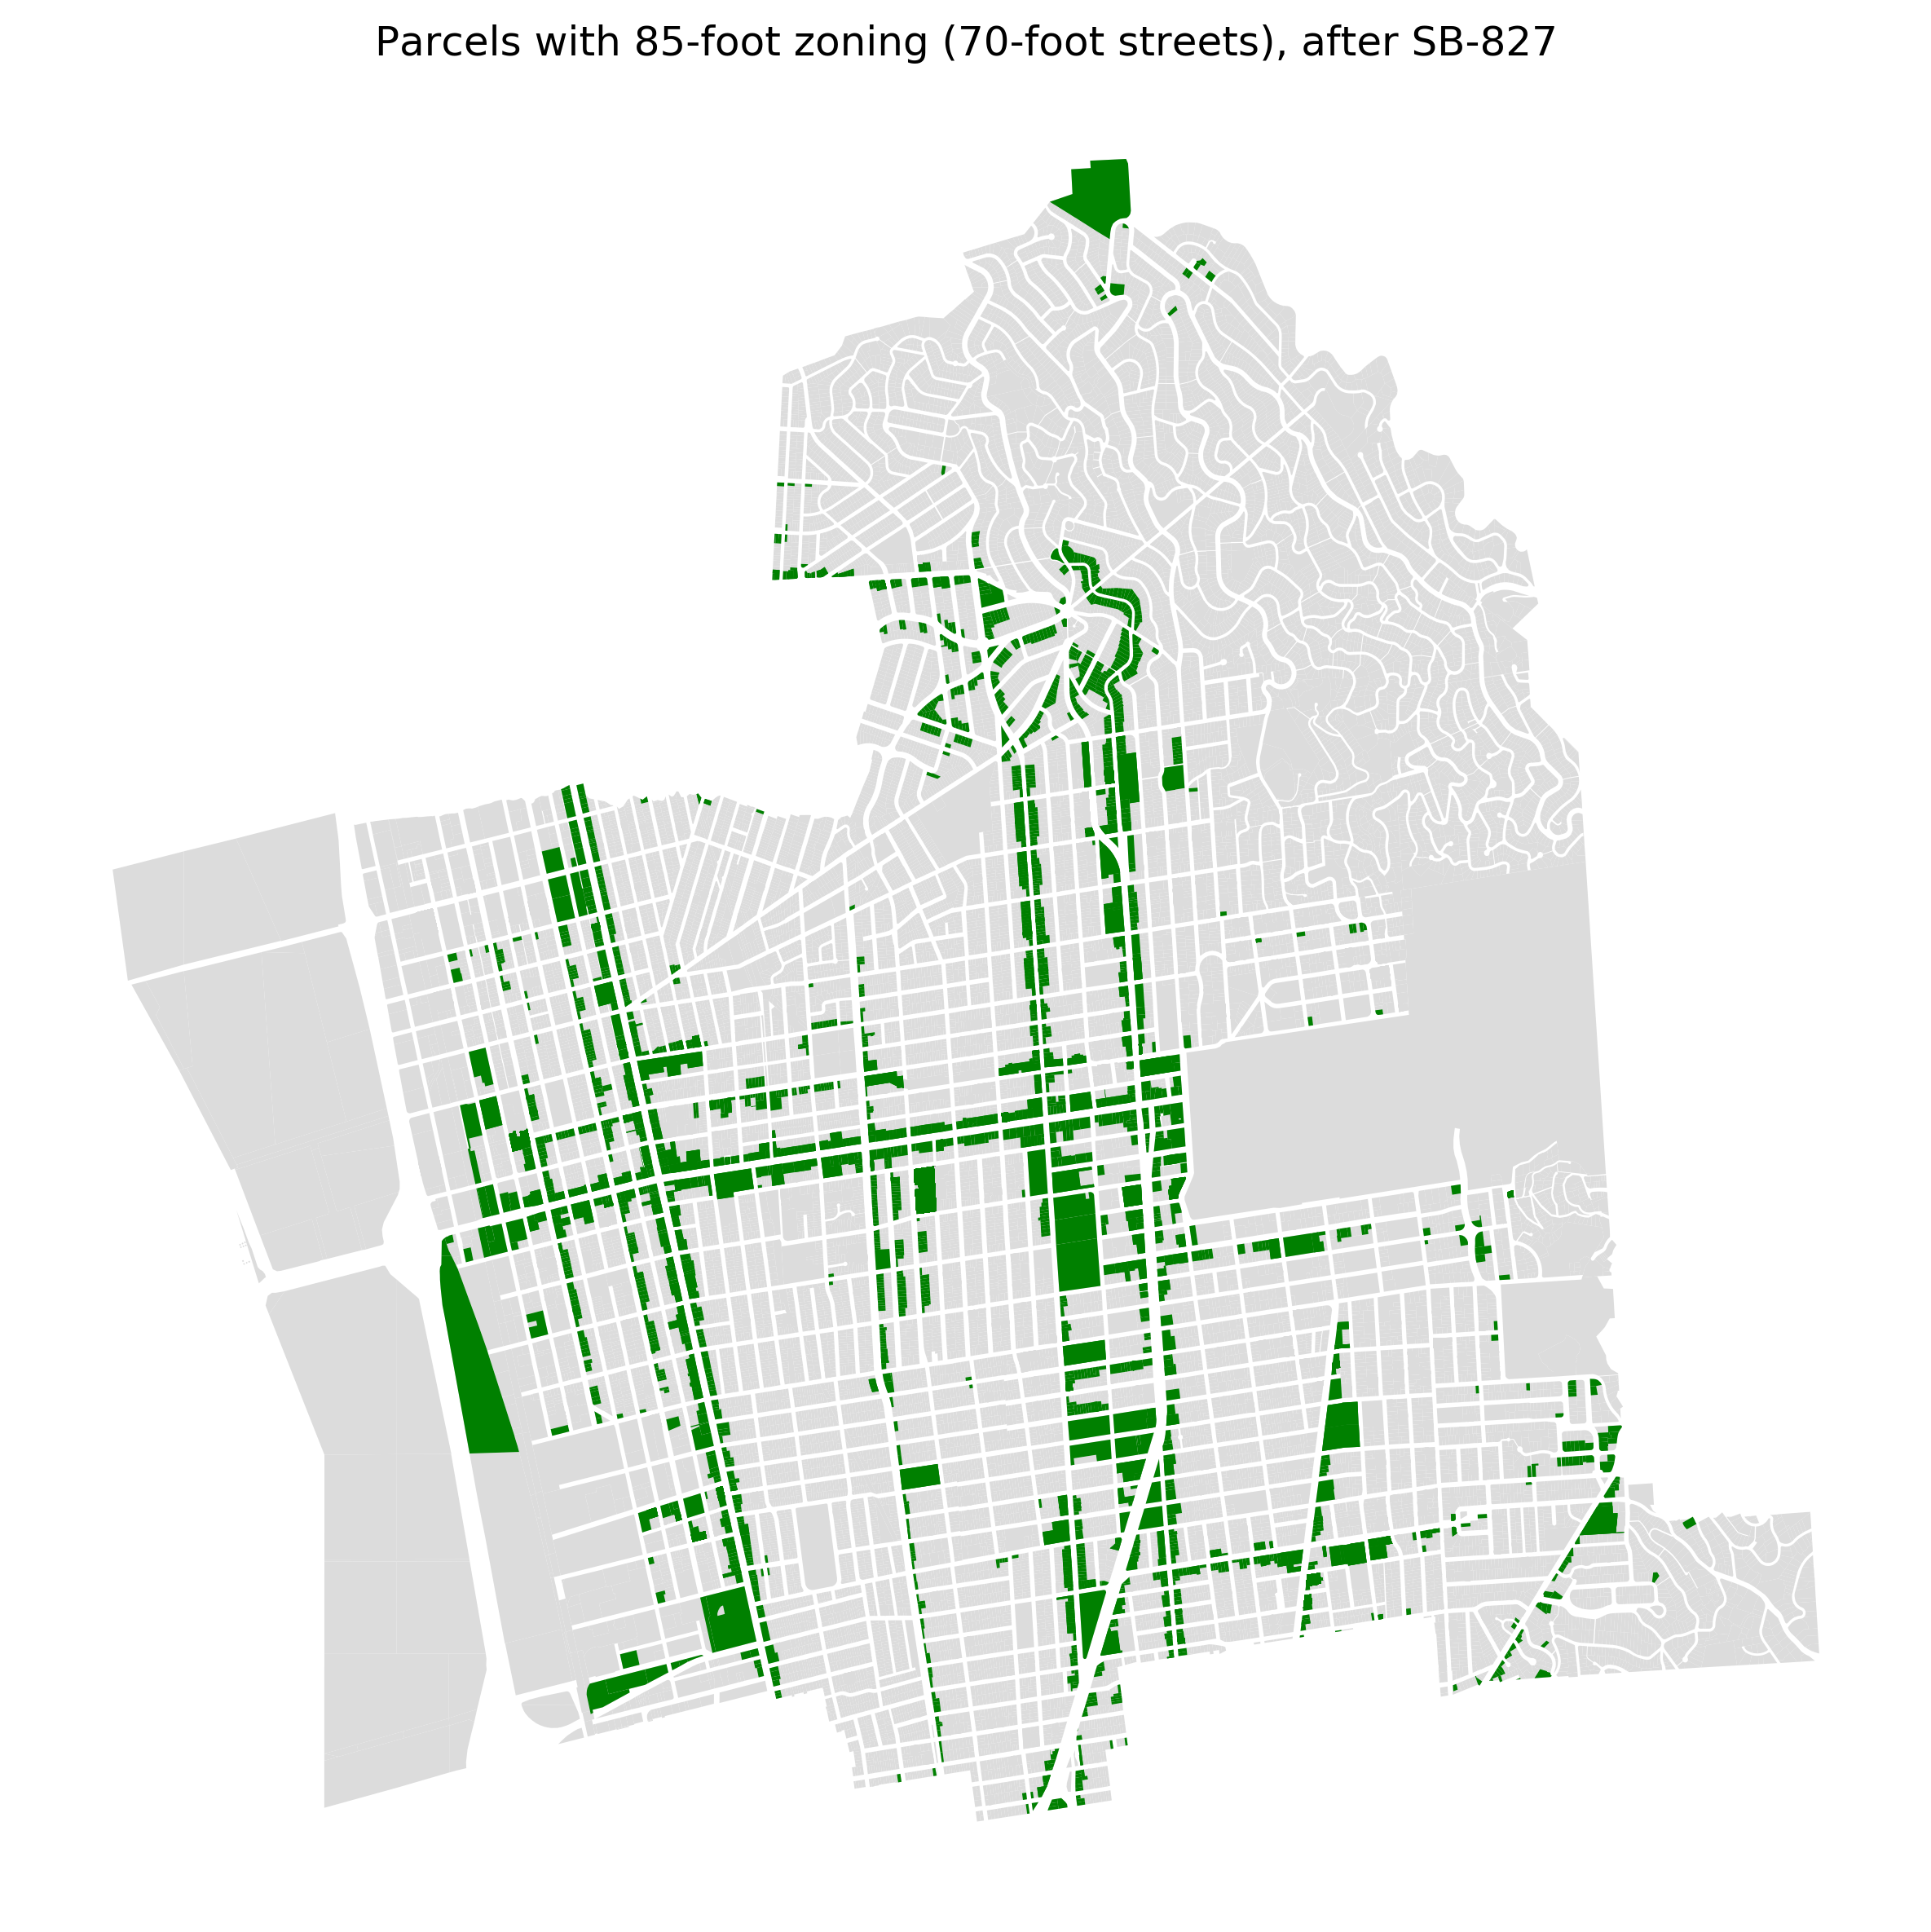

In [64]:
f = plt.gcf()
ax = f.gca()
ax.set_title('Parcels with 85-foot zoning (70-foot streets), after SB-827')
plot_dataframe(all_parcels, ax=ax, facecolor='gainsboro', zorder=0)
plot_dataframe(eighty_five_parcels, ax=ax, facecolor='green', zorder=1)
f.set_size_inches(8, 8)

save_map(f, ax, "figs/berkeley/berkeley-sb827-parcels-wide-streets-70ft-buffer-all-parcels.png", dpi=300)
save_map(f, ax, "figs/berkeley/berkeley-sb827-parcels-wide-streets-70ft-buffer-all-parcels-1200dpi.png", dpi=1200)

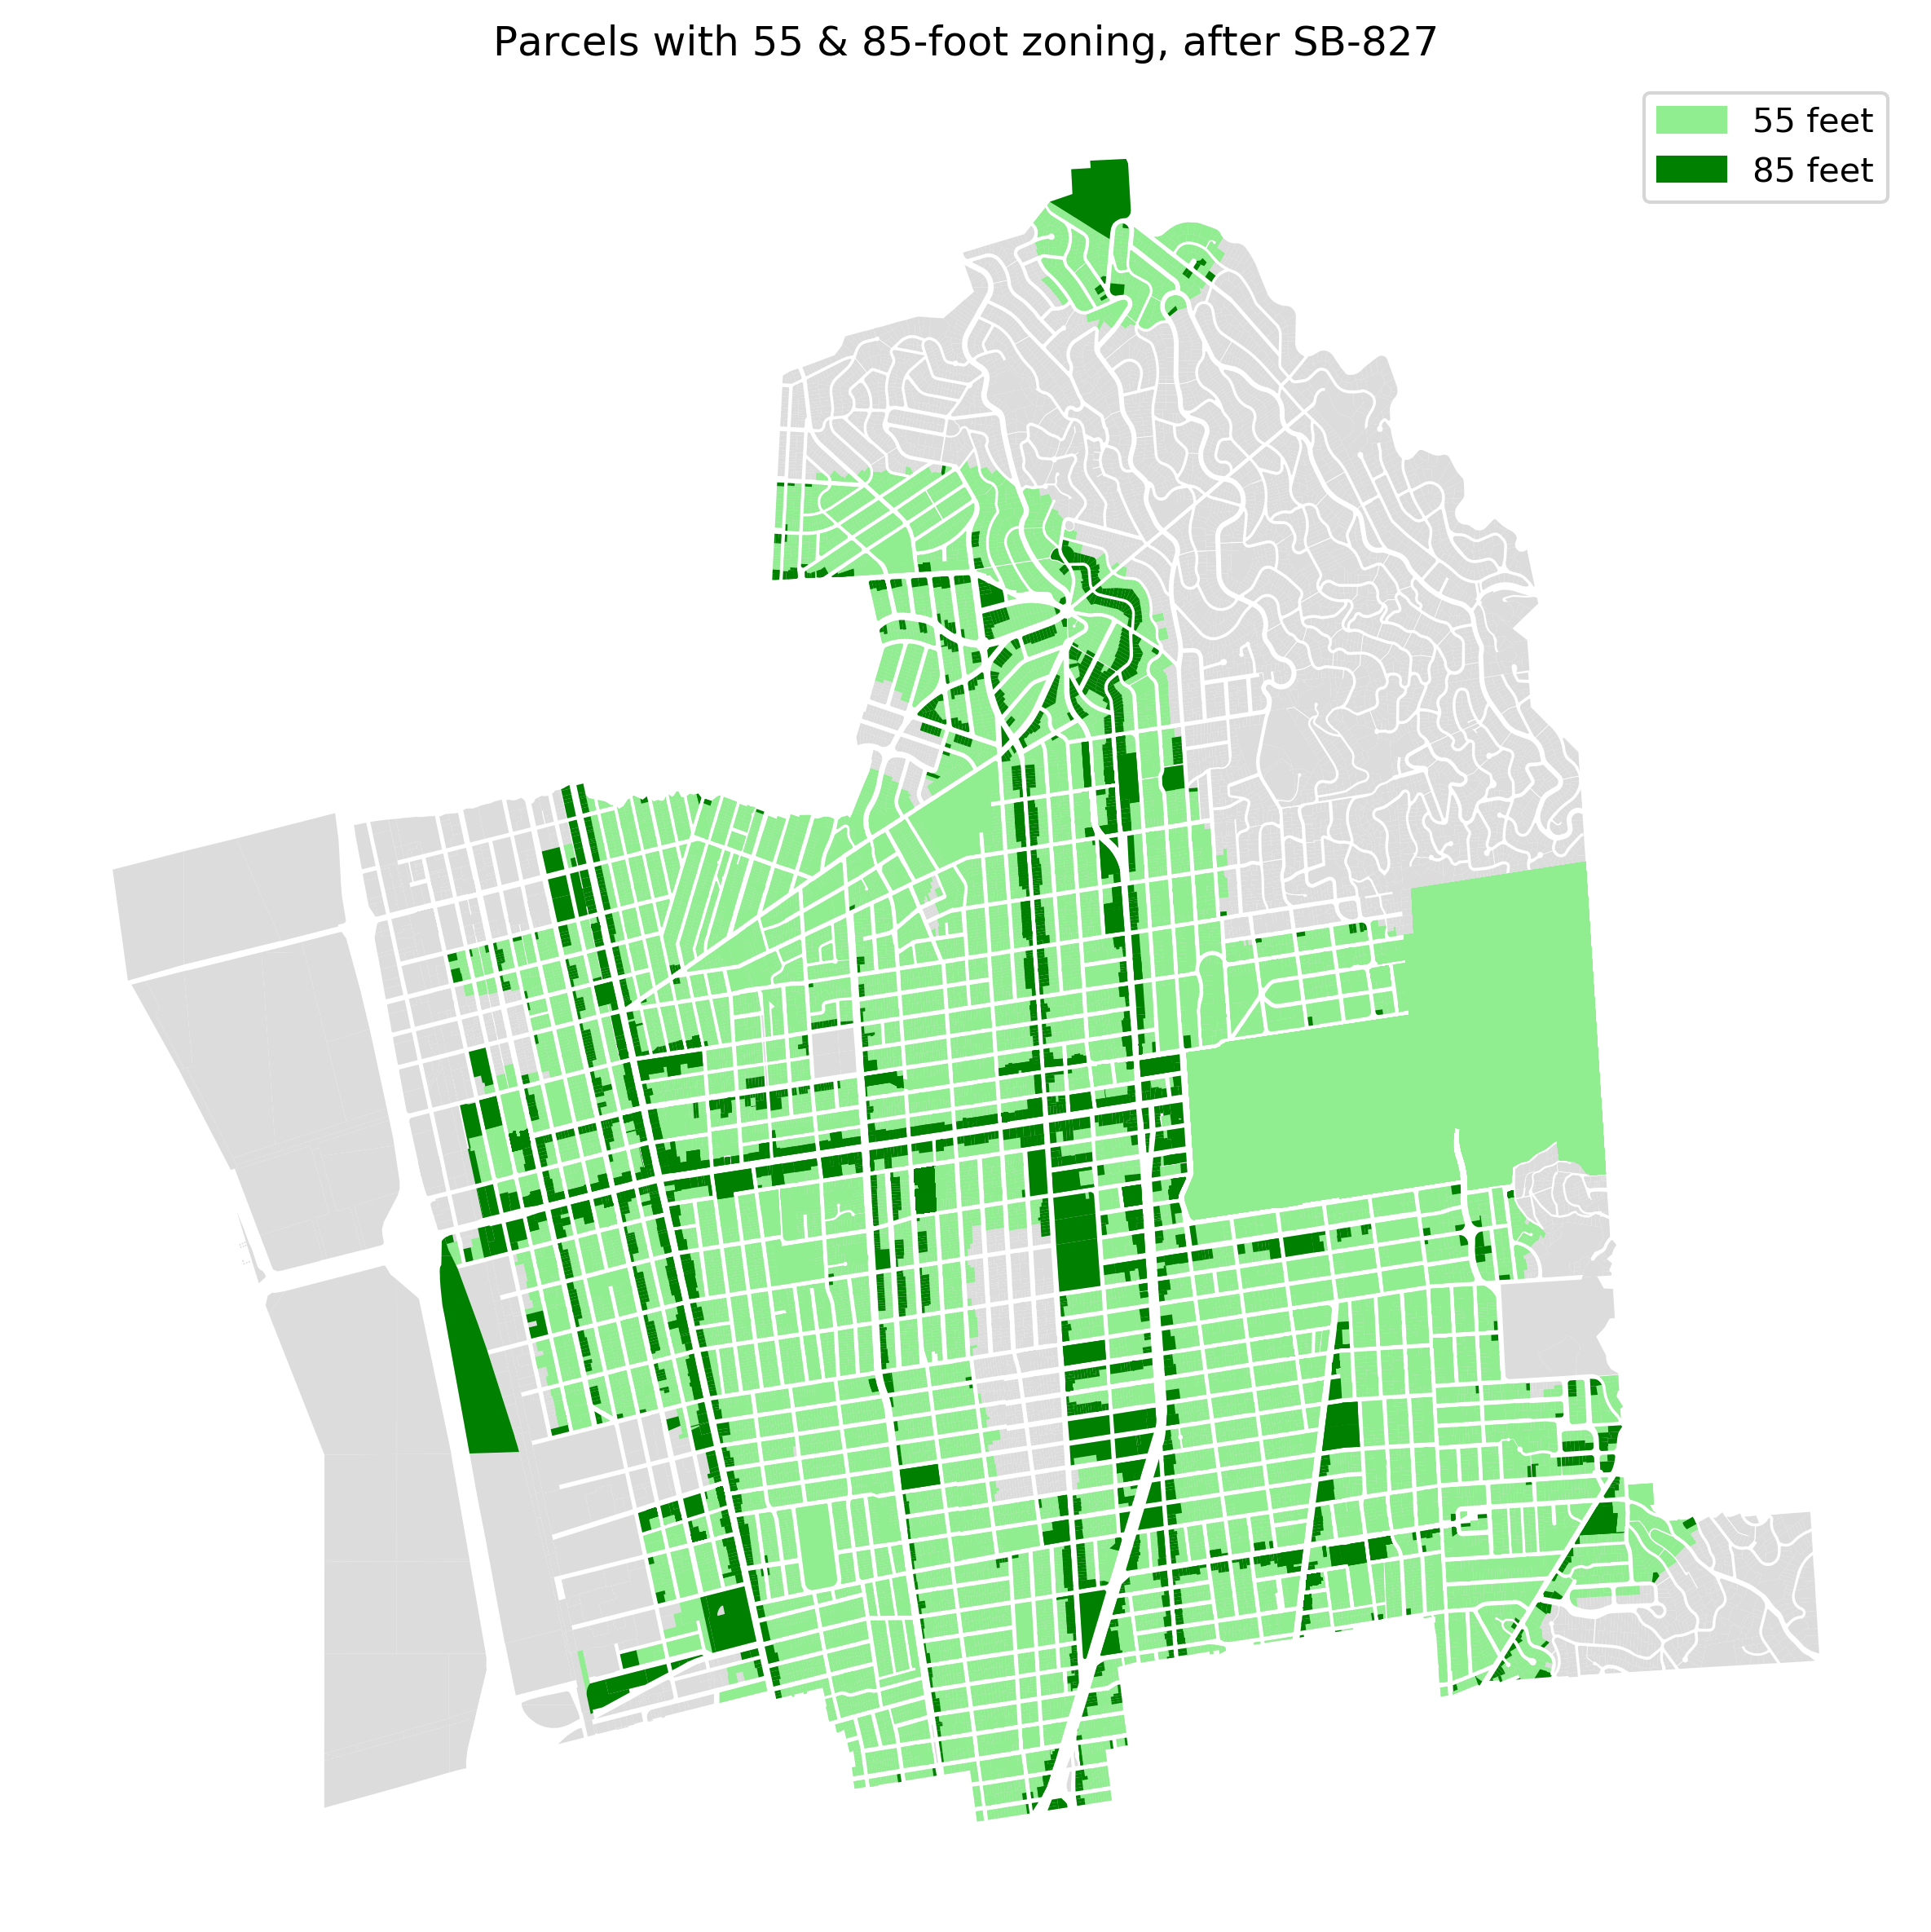

In [63]:
f = plt.gcf()
ax = f.gca()
ax.set_title('Parcels with 55 & 85-foot zoning, after SB-827')
plot_dataframe(all_parcels, ax=ax, facecolor='gainsboro', zorder=0)
plot_dataframe(fifty_five_parcels, ax=ax, facecolor='lightgreen', zorder=1)
plot_dataframe(eighty_five_parcels, ax=ax, facecolor='green', zorder=2)
f.set_size_inches(8, 8)

try:
    import matplotlib.patches as mpatches
    import matplotlib.pyplot as plt

    fifty_five = mpatches.Patch(color='lightgreen', label='55 feet')
    eighty_five = mpatches.Patch(color='green', label='85 feet')
    plt.legend(handles=[fifty_five, eighty_five])
except:
    pass
save_map(f, ax, "figs/berkeley/berkeley-sb827-all-parcels.png")
save_map(f, ax, "figs/berkeley/berkeley-sb827-all-parcels-1200dpi.png", dpi=1200)

# Difference

In [92]:
zoning_to_height = {
    # Strictly residential
    'R-1': 28,
    'R-1A': 28,
    'R-1H': 28,
    'R-2': 28,
    'R-2A': 28,
    'R-2AH': 28,
    'R-2H': 28,
    'R-3': 35,
    'R-3H': 35,
    'R-4': 35,
    'R-4H': 35,
    'R-5': 35,
    'R-5H': 35,
    'R-S': 35,
    'R-SH': 35,
    'C-N': 35,
    'C-N(H)': 35,
    'C-NS': 35,
    'C-NS(H)': 35,
    
    # Other
    'C-1': 40,
    'C-E': 28,
    'C-SA': 50, # averaged, real regulations are weird
    'C-SO': 28,
    'C-W': 40,
    'MUR': 35,   
    'C-DMU Buffer': 50,
    'C-DMU Core': 60,
    'C-DMU Corridor': 60,
    'C-DMU Outer Core': 60,
    'C-T': 35,  # C-T allows R-3, so this is a guess
    'R-SMU': 35  # I have no idea, height limits aren't defined anywhere
}

In [111]:
residential_parcels_with_heights = residential_parcels.copy(deep=True)
hdx = []
for idx, row in residential_parcels_with_heights.iterrows():
    hdx.append(zoning_to_height[row['zoning']])
residential_parcels_with_heights['height'] = hdx
                
residential_parcels_with_heights.loc[eighty_five_parcels.index, 'difference'] = 85 - residential_parcels_with_heights.loc[eighty_five_parcels.index, 'height']
residential_parcels_with_heights.loc[fifty_five_parcels.index, 'difference'] = 55 - residential_parcels_with_heights.loc[fifty_five_parcels.index, 'height']

idx = (residential_parcels_with_heights['difference'] < 1) | (pd.isna(residential_parcels_with_heights['difference']))
residential_parcels_with_heights.loc[idx,'difference'] = 0

residential_parcels_with_heights['floors'] = np.floor_divide(residential_parcels_with_heights['difference'], 10)
residential_parcels_with_heights[residential_parcels_with_heights['floors'] <= 0] = 0.0
residential_parcels_with_heights['floors'] = residential_parcels_with_heights['floors'].astype(int)

residential_parcels_with_heights.to_file('gis/berkeley/computed-residential_parcels_with_heights.geojson', driver="GeoJSON")

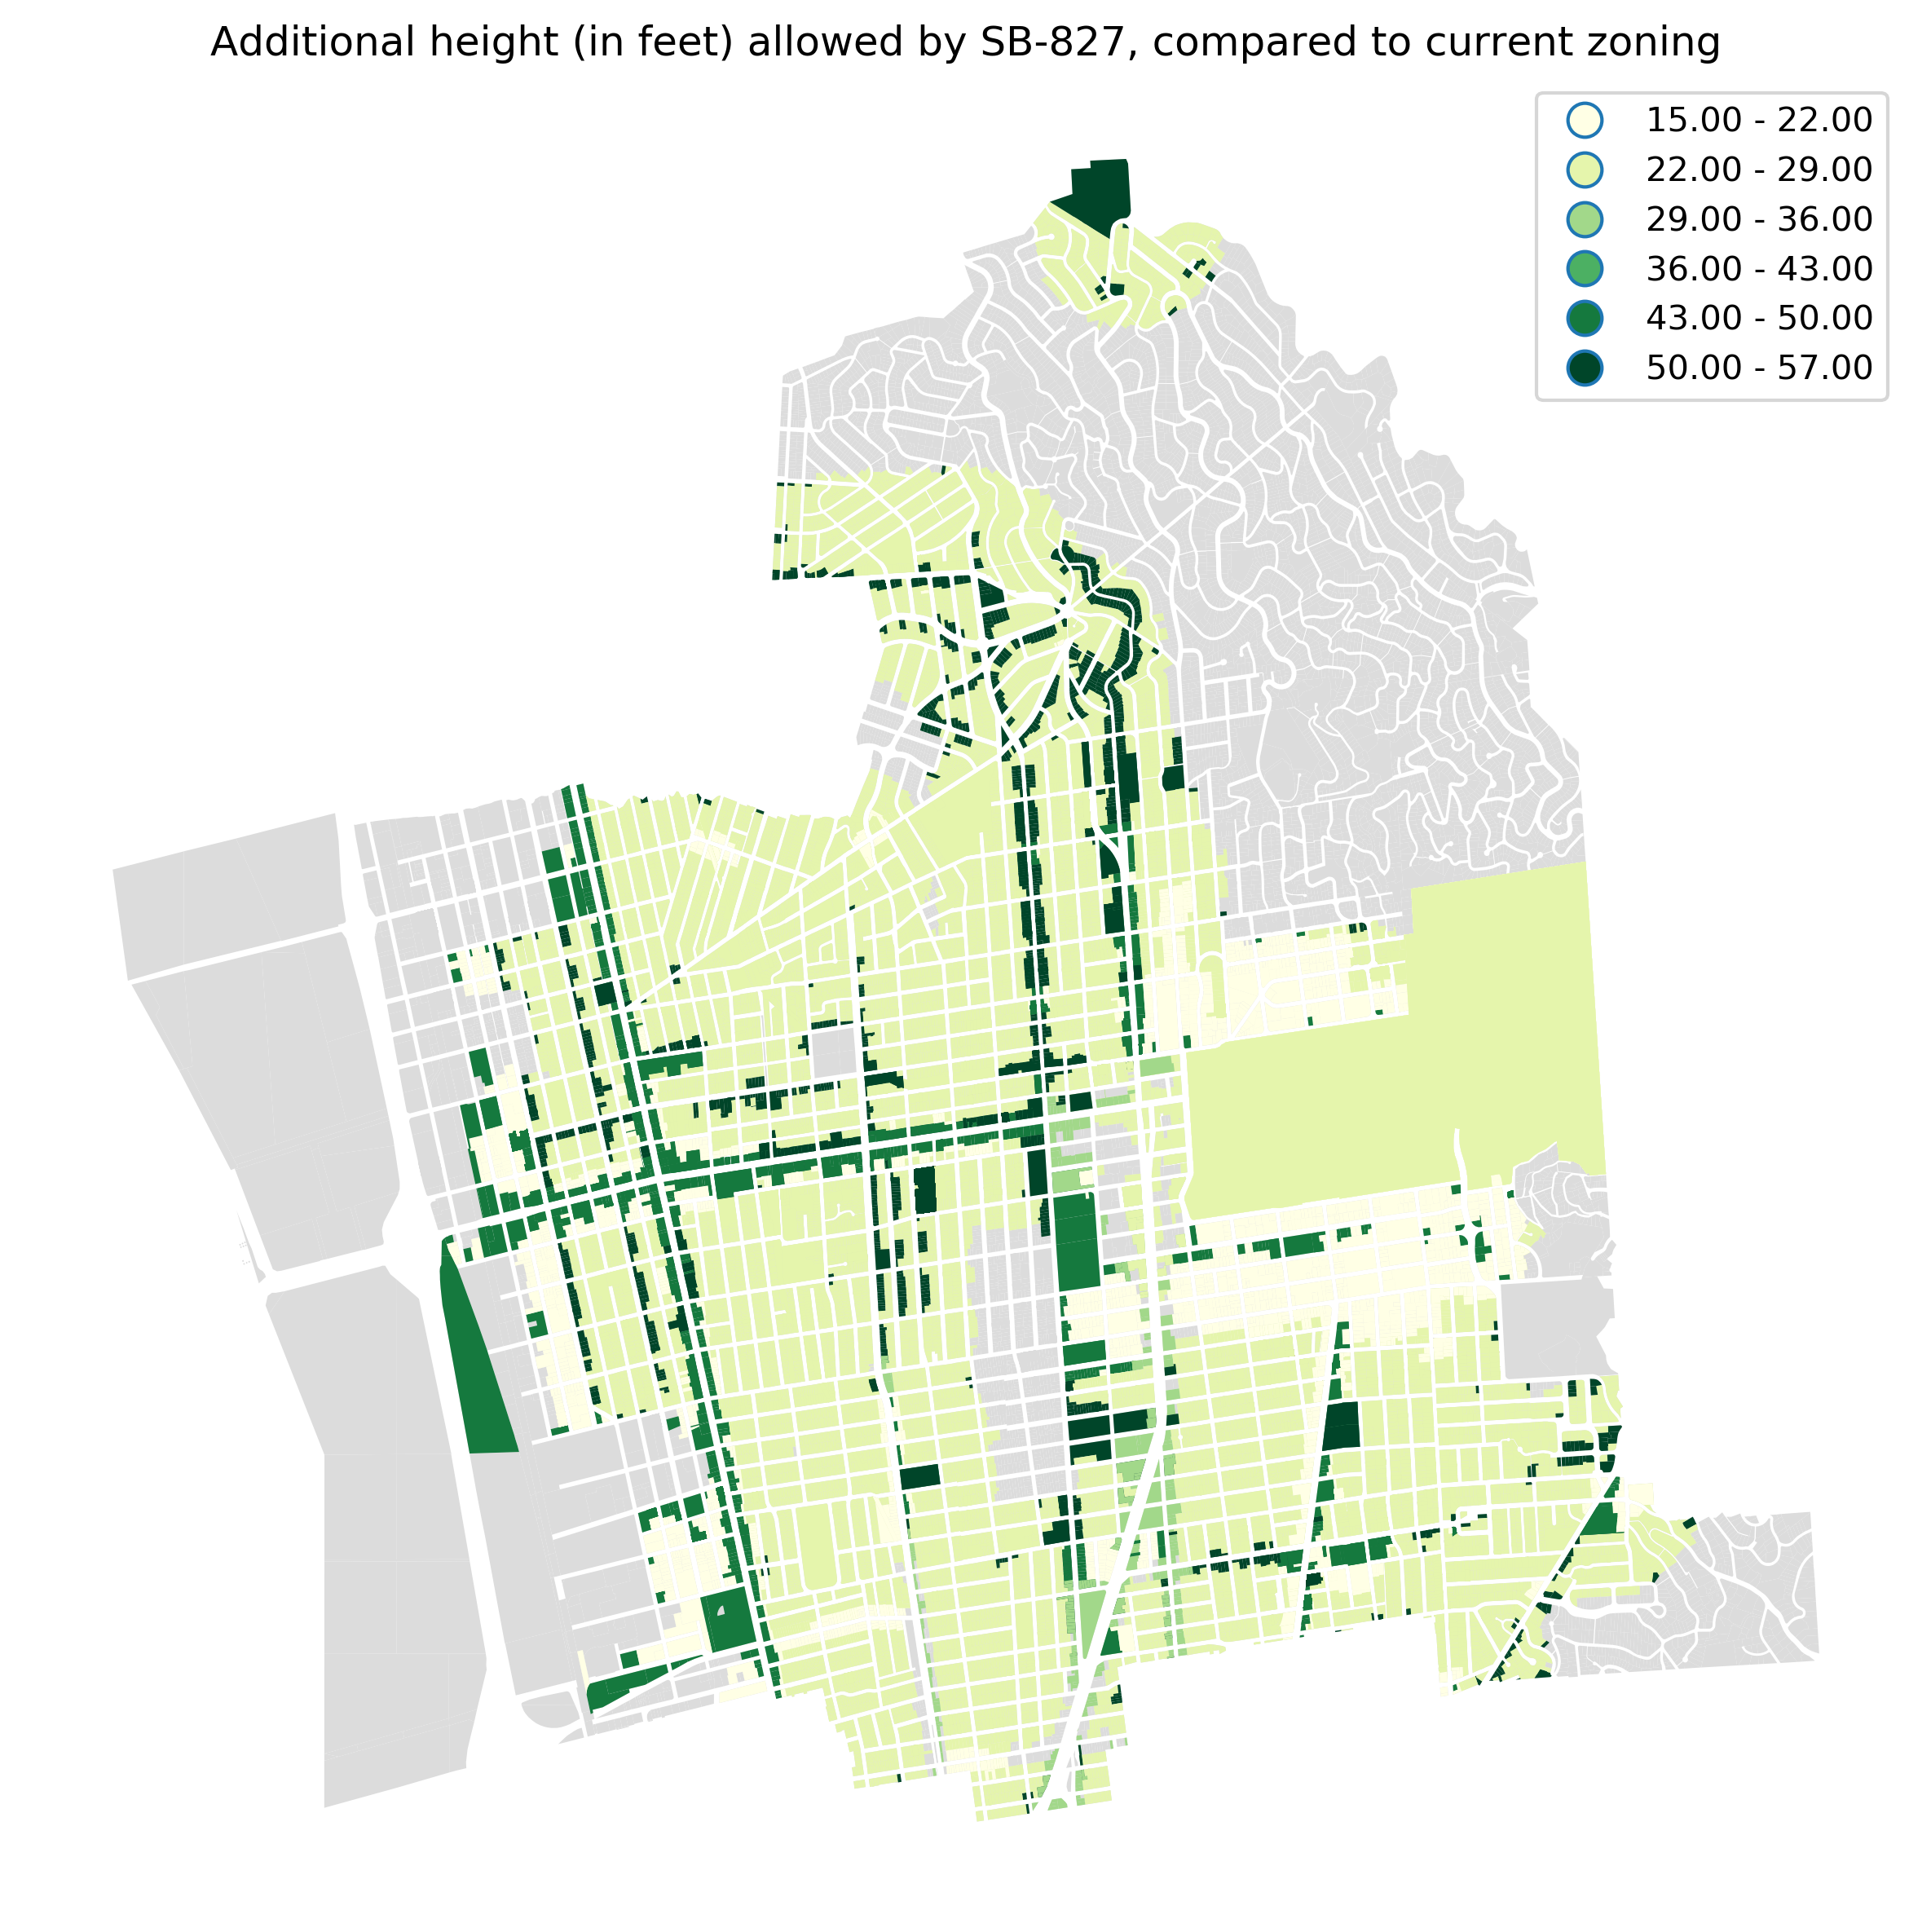

In [106]:
from matplotlib.colors import ListedColormap
my_cmap = ListedColormap(sns.light_palette("green").as_hex())

f = plt.gcf()
ax = f.gca()
ax.set_title('Additional height (in feet) allowed by SB-827, compared to current zoning')
plot_dataframe(all_parcels, ax=ax, facecolor='gainsboro', zorder=0)
plot_dataframe(residential_parcels_with_heights[residential_parcels_with_heights['difference'] > 0],
               ax=ax, k=6, column='difference', scheme='equal_interval', cmap='YlGn', legend=True, zorder=1)

f.set_size_inches(8, 8)
save_map(f, ax, "figs/berkeley/sb827-upzoned-parcels.png", dpi=300)
save_map(f, ax, "figs/berkeley/sb827-upzoned-parcels-1200dpi.png", dpi=1200)

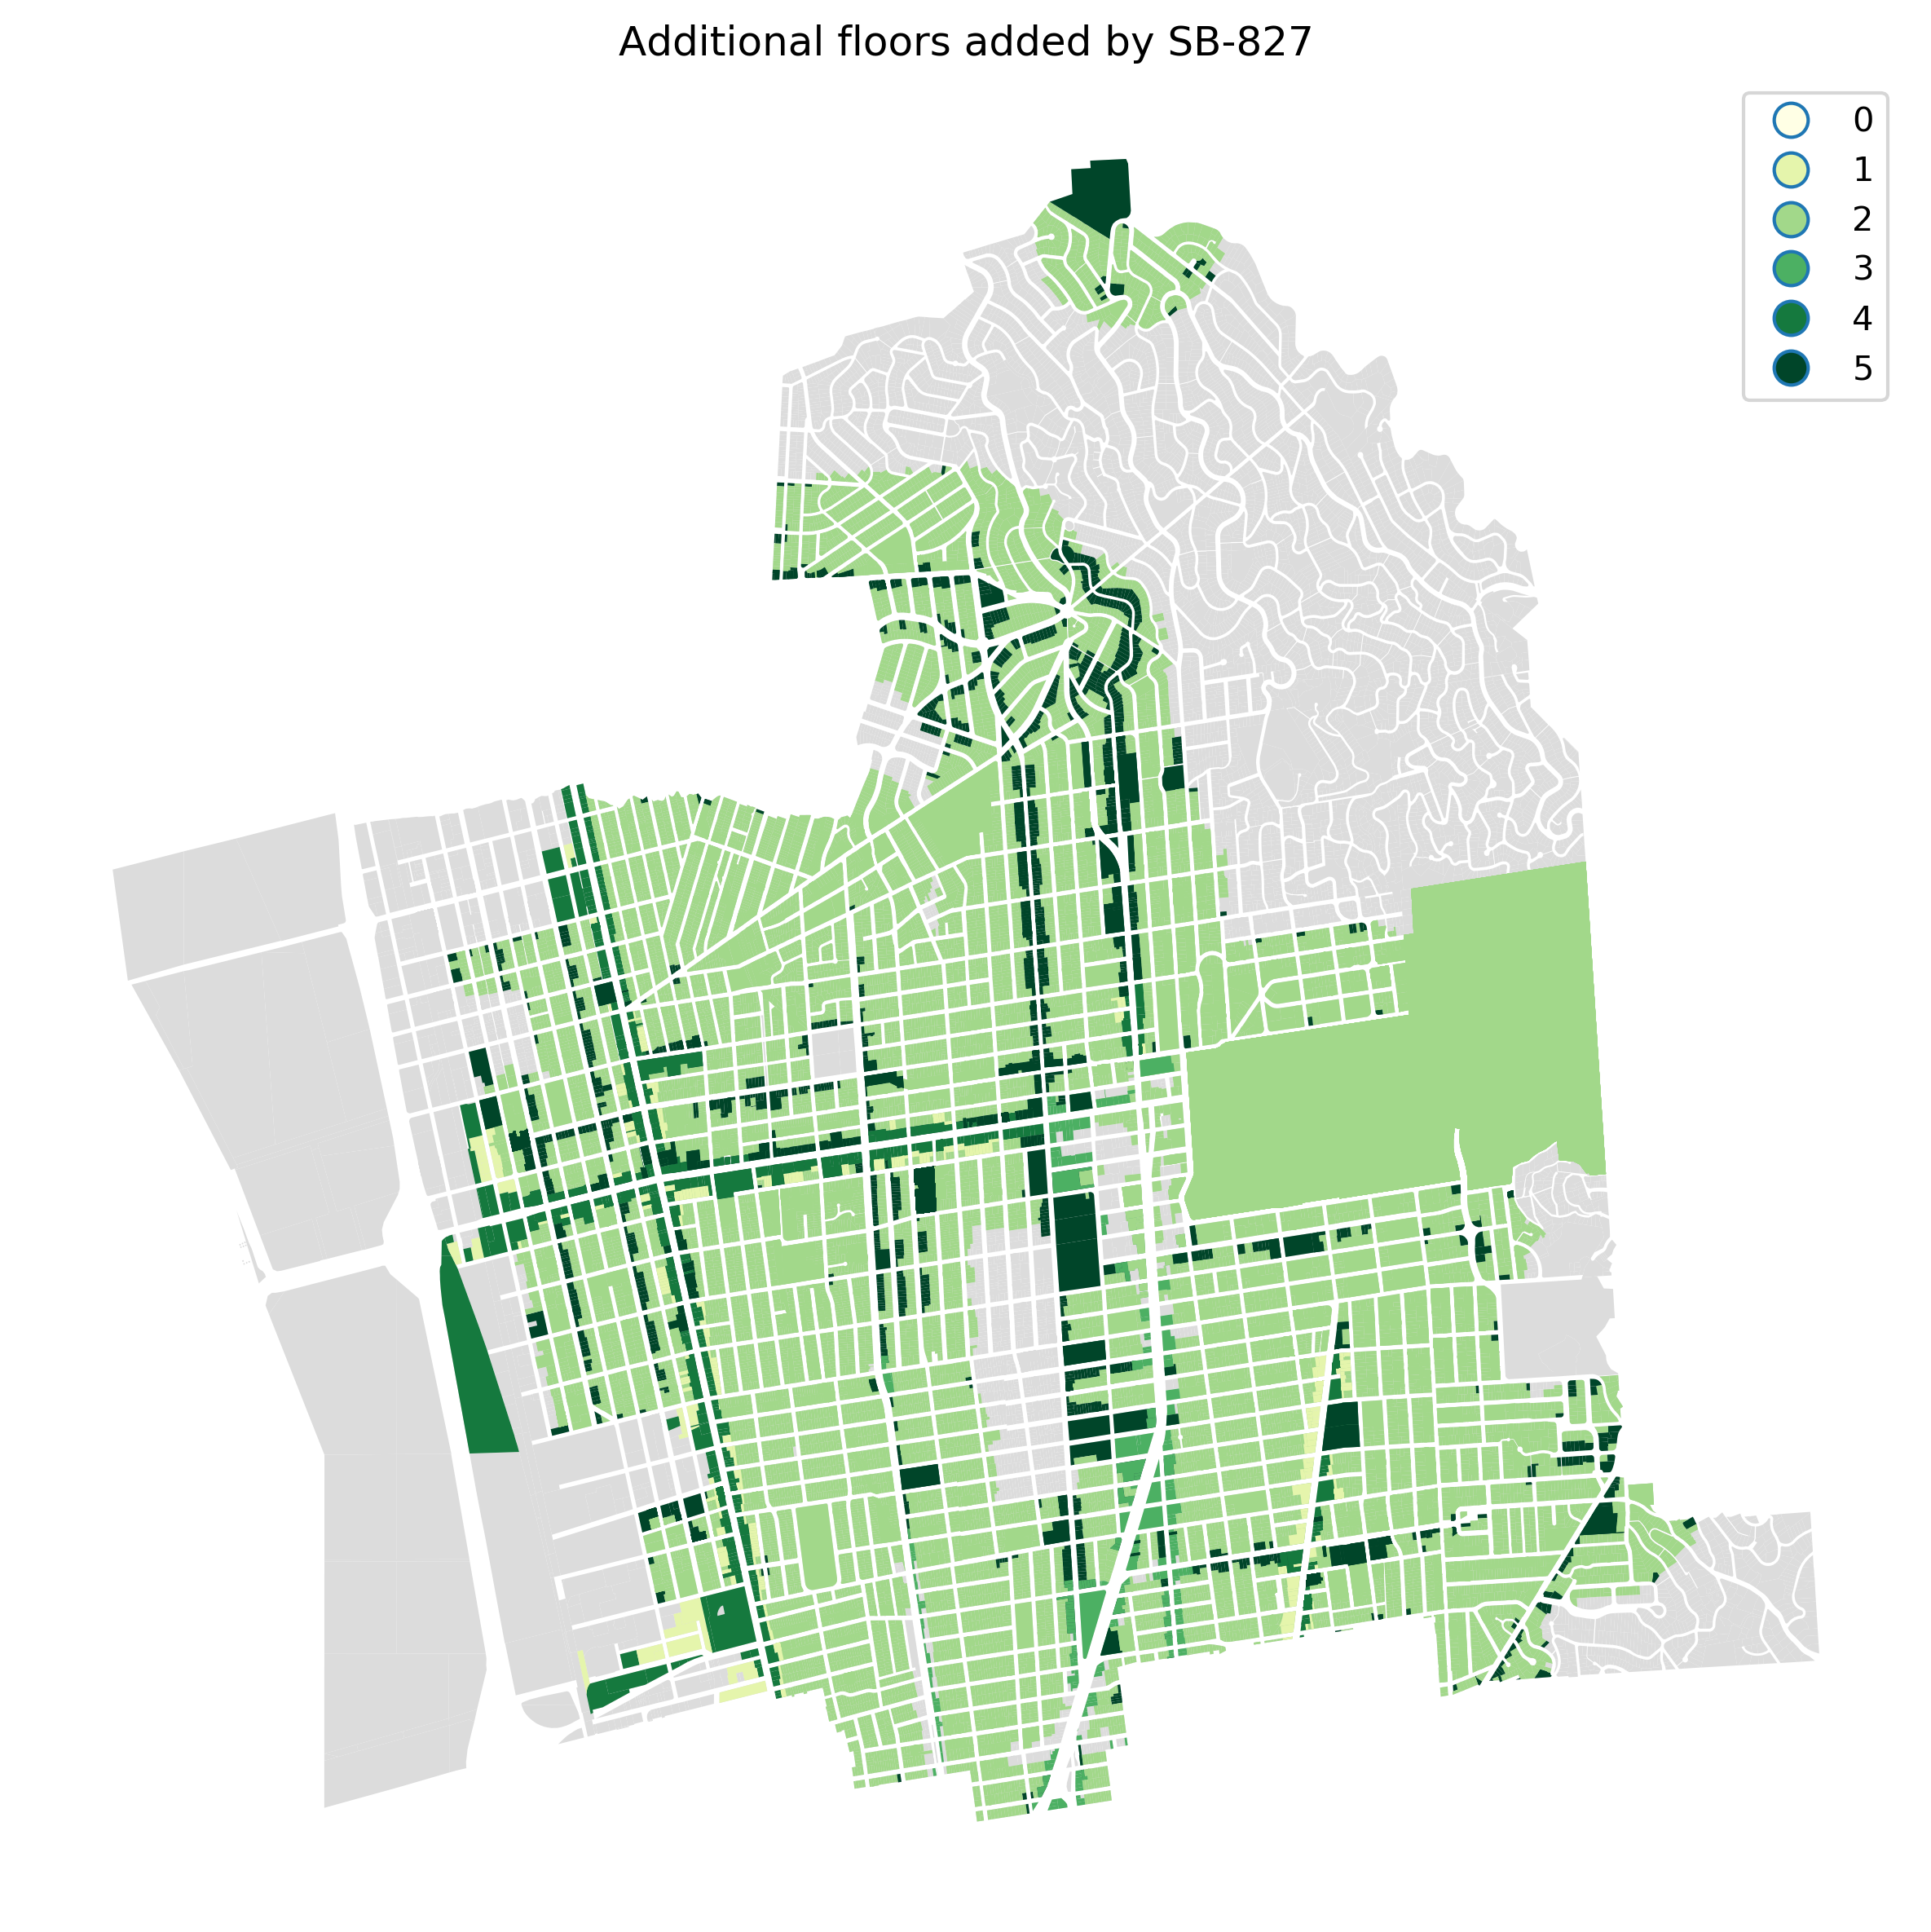

In [107]:
from matplotlib.colors import ListedColormap
my_cmap = ListedColormap(sns.light_palette("green").as_hex())

f = plt.gcf()
ax = f.gca()
ax.set_title('Additional floors added by SB-827')
plot_dataframe(all_parcels, ax=ax, facecolor='gainsboro', zorder=0)
plot_dataframe(residential_parcels_with_heights, ax=ax, categorical=True,
               column='floors', cmap='YlGn', legend=True, zorder=1)

ax.get_legend().set_bbox_to_anchor((1, 1))

f.set_size_inches(8, 8)
save_map(f, ax, "figs/berkeley/sb827-new-floors.png", dpi=300)
save_map(f, ax, "figs/berkeley/sb827-new-floors-1200dpi.png", dpi=1200)